# <center>Web Scraping Brookline Property Listings with Beautiful Soup<center>

___________

Are you looking for a property in Brookline? Then boy, do I have something for you!

I started this project after I came across the concept of Web Scraping on Reddit. I knew a bit about HTML and thought it would be a good way to further my Python skills and also just a fun project. The library I'm using is called Beautiful Soup; it allows you to parse through the HTML (website language) of different sites and use that data however you like. 

I decided on the idea of parsing through property listings because I wanted the result to at least have useful potential. After Googling "Brookline properties" the first time, I was going to use Zillow.com but their website didn't allow scraping (you can find out if a site does by going to their .com/robots.txt). 

Ultimately, I chose to use https://www.coldwellbankerhomes.com/ma/brookline/ to scrape. I honestly don't know why I settled on Coldwell Banker's site, it wasn't the easiest to use but I liked the challenge. Once I looked at the page source and got a general idea for the website's HTML, I began to use Beautiful Soup to test grabbing certain elements. 


I'll be breaking this project down into three main parts:

1) Looking at HTML and grabbing some data 

2) Automating that process for as many pages as Coldwell Banker allows me

3) Doing some exploratory analysis of the resulting dataset

## Exploring the HTML

First, we have to import everything and set up the web scraper. The latter is copied from Albon Notes (https://chrisalbon.com).

In [1]:
# Importing libraries
import requests # allows us to send HTTP requests
from bs4 import BeautifulSoup # web scraper
import re # regex which will be used for the third div
import pandas as pd # for dataframe assembly
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# This is copied from Albon Notes
url = 'https://www.coldwellbankerhomes.com/ma/brookline/' # Create a variable with the url
r = requests.get(url) # Use requests to get the contents
html_content = r.text # Get the text of the contents
cb = BeautifulSoup(html_content, 'lxml') # Convert the html content (cb = Coldwell Banker) into a beautiful soup object

Check the title of this webpage:

In [2]:
cb.title.text

'Brookline, MA Homes For Sale & Real Estate'

Perfect, now let's find the HTML we care about. 

#### Grabbing the Divs

HTML is typically broken into "div" sections, as is the case for CB. Each property listing is contained in a parent div that contains a div for the photo on the left and a div for the property info on the right with class "prop-info". We can grab that using the <strong>select</strong> method in Beautiful Soup.

In [3]:
propinfo = cb.select(".prop-info") # grabbing the class "prop-info" (.prop-info signals it's a class)

In [4]:
# How many properties on the first page?
len(propinfo)

24

In [5]:
# Let's see what the first property's info looks like:
print(propinfo[1].text.strip())

705 Hammond St 
#B 
Brookline, MA 02467
$1,950,000


Townhouse
Active
MLS # 72573312
Updated 17 hours ago

4Beds
3Full Baths
1Partial Bath
4Total Baths
2,900Sq. Ft.
2Car Garage

Listed by Todd Glaskin (617) 843-5685 and Gregg Leppo (781) 710-0592




HideContactShareMap


I used ".text.strip" here because the raw HTML for ".prop-info" is too lengthy. This div's HTML is broken down into four divs, the last of which contains the "HideContactShareMap" buttons that we won't need. We'll grab the first three to see what they look like, again doing so by selecting the class of their div:

In [6]:
addprice = cb.select(".address-price-etc") # addresses and prices
descrip = cb.select(".description-summary") # just going to get the property type from this one
bbsg = cb.select(".highlights") # beds, baths, sq ft, garage

In [7]:
# Let's make sure we have 24 of these too
print(len(addprice), len(descrip), len(bbsg) )

24 24 24


#### Example of Address and Price

In [8]:
# HTML for the first listing
addprice[0]

<div class="address-price-etc"><div class="address notranslate"><a href="/ma/brookline/705-hammond-st-b/pid_32689009/"><div class="street-address-unit"><div class="street-address">705 Hammond St </div>
<div class="unit-number">#B </div>
</div><div class="city-st-zip">Brookline, MA 02467</div></a></div><div class="price-block-hpa-other"><div class="price-block"><div class="price">
<div class="price-normal">$1,950,000</div>
</div></div><div class="hpa-price-other">
</div></div></div>

As you can see, the div with class ".address-price-etc" is broken into *more* divs. This makes life easy for us because each of these divs have their own class. For instance, let's print the first five addresses:

In [9]:
addresses = cb.select(".street-address")
for i in range(5):
    print(addresses[i].text.strip())

705 Hammond St
705 Hammond St
101 Summit Ave
955 Hammond St
1755 Beacon St


#### Creating a loop to get the info for each listing:

Figuring out how to scrape each piece of information I wanted was a challenge. The other two divs weren't broken down as cleanly as "addprice" -- they were in the form of lists rather than smaller divs. Lists are incredibly difficult to work with in Beautiful Soup because each element doesn't have its own class name like most divs do, making them harder to select especially when the length or order is inconsistent.

For the second div (".description-summary"), the only info I was concerned with was the property type (Condo, Single-Family, etc). Luckily, the property type was always listed as the first element in each of the second div's lists. I created a formula for the class name for each property's div (which grew +1 for each property) and got the first element in the div's list to extract this info. 

The third div's (".highlights") info was complicated since the info was in list form and the order and length was inconsistent. The only way I knew of to grab the info for beds, baths, garages and square feet was by using something called RegEx (regular expression). RegEx has a feature that lets you search for the digits before a phrase, so I got the text for ".highlights" and searched for the digits before the phrase "Bed", "Total Bath", "Sq", and "Car Garage". I needed to include exceptions for garages and beds because some properties didn't have info for those two; I made those values zero. Additionally, a small number of properties were listed in acres instead of square feet. I ultimately decided to ignore those listings. 

At the beginning of the code I create empty lists for each info type we want. Once scraped, that info will go into a Pandas DataFrame. By doing it this way, we can loop over this code for each page's URL since the empty list is created anew each time. 

*Anyways.* Here's what the loop for the first page ended up looking like:

In [10]:
staddress = cb.select(".street-address") # address div
prices_ = cb.select(".price") # price div
descrip = cb.select(".description-summary") # property type div
bbsg = cb.select(".highlights") # beds, baths, sq ft, garages div
beds = []
tbaths = []
types = []
addresses = []
prices = []
sqft = []
garages = []
unit = "Unit"
for i in range(24):
        info3_ = bbsg[i].text # getting info for third div
        info3 = info3_.replace(',','') # deleting the ',' in sqft value
        if unit in info3: # ignoring listings that are units
            pass
        else:
            # first div
            addresses.append(staddress[i].text.strip()) # Addresses done
            prices.append(prices_[i].text.strip()) # Prices done
            # second div
            snapshot = cb.select("#snapshot-" + str(i) + " .description-summary li")
            types.append(snapshot[0].text) # Type done
            # third div
            bed = re.findall(r"(\d+)Bed", info3)
            if bed:
                pass
            else:
                bed = ['0'] # some listings don't have beds (listed)
            beds = beds + bed # Beds done
            tbath = re.findall(r"(\d+)Total Bath", info3)
            tbaths = tbaths + tbath # Total baths done
            nft = re.findall(r"(\d+)Sq", info3)
            sqft = sqft + nft # Sqft done
            ngarages = re.findall(r"(\d+)Car Garage", info3)
            if ngarages:
                pass
            else:
                ngarages = ['0'] # some listings don't have garages
            garages = garages + ngarages # Garages done

Now, I put these each info's list into a Pandas DataFrame:

In [16]:
df = pd.DataFrame({'Address': addresses, 
                    'Price': prices, 
                    'Property Type': types, 
                    'Beds': beds, 
                    'Baths': tbaths, 
                    'Square Feet': sqft, 
                    'Garages': garages})
df

,Address,Price,Property Type,Beds,Baths,Square Feet,Garages
0,65 Glen Rd,"$649,000",Condo,2,2,1189,0
1,66 Norfolk Rd,"$2,195,000",Single Family,4,5,3896,2
2,533 Boylston St,"$1,495,000",Townhouse,4,4,2892,2
3,612 Newton St,"$2,395,000",Single Family,6,6,5436,2
4,204 Clyde St,"$7,500,000",Single Family,6,8,7502,3
5,18 Fisher Ave,"$4,600,000",Single Family,5,6,4859,2
6,38 Welch Rd,"$3,475,000",Single Family,7,7,6943,2
7,19 Harris St,"$1,230,000",Townhouse,3,3,1531,0
8,65 Glen Rd,"$589,000",Condo,2,2,949,0
9,156 Ivy St,"$5,595,000",Single Family,5,5,6747,3


Pretty cool! I like the look of this and am ready to move onto to placing this loop into a bigger loop that will iterate over each page's URL to get all the listings we possibly can. 

## Iterating over each page's URL

Because we set up the code so nicely to loop over, all we have to do now is create a formula for each page's URL and a system to add the DataFrame to a master DF. The first thing to do is to create this DF outside of the loop so that it doesn't get written over every time the loop iterates over a page. 

In [20]:
listings = pd.DataFrame()

Next, we make a formula for the URL for each page of listings. The URL for each page ends with the page number * 24 which makes it easy enough to code. We then use the Requests and Beautiful Soup libraries again to get the page source. Then we get the class info again and can perform the loop. 

The loop is going to be 6 iterations long because Coldwell Banker only lets us see a certain number of properties for free. At the end of each loop we'll add the resulting lists to a DataFrame and add that DF to our grand DF.

Let's loop:

In [21]:
for j in range(0,6):
    num = 24*j
    url = 'https://www.coldwellbankerhomes.com/ma/brookline/?sortId=2&offset=' + str(num)

    # Setting up
    r = requests.get(url)
    html_content = r.text
    cb = BeautifulSoup(html_content, 'lxml') 
    
    # Getting HTML
    # First div classes we need for address and price
    staddress = cb.select(".street-address")
    prices_ = cb.select(".price")
    # Second div classes
    proptype = cb.select(".description-summary li")
    # Third div classes
    bbsg = cb.select(".highlights") # beds, baths, sq ft, garage
    
    # Performing the loop
    beds = []
    tbaths = []
    types = []
    addresses = []
    prices = []
    sqft = []
    garages = []
    unit = "Unit"
    for i in range(24):
        info3_ = bbsg[i].text # getting info for third div
        info3 = info3_.replace(',','') # deleting the ',' in sqft value
        if unit in info3: # ignoring listings that are units
            pass
        else:
            # first div
            addresses.append(staddress[i].text.strip())
            prices.append(prices_[i].text.strip()) # Prices done
            # second div
            
            
            snapshot = cb.select("#snapshot-" + str(num + i) + " .description-summary li")
            types.append(snapshot[0].text) # getting type
            #print(num+i)
            
            
            # third div
            bed = re.findall(r"(\d+)Bed", info3)
            if bed:
                pass
            else:
                bed = ['0']
            beds = beds + bed # Beds done
            tbath = re.findall(r"(\d+)Total Bath", info3)
            tbaths = tbaths + tbath # Total baths done
            nft = re.findall(r"(\d+)Sq", info3)
            sqft = sqft + nft # Sqft done
            ngarages = re.findall(r"(\d+)Car Garage", info3)
            if ngarages:
                pass
            else:
                ngarages = ['0'] # some listings don't have garages
            garages = garages + ngarages # Garages done
    df = pd.DataFrame({'Address': addresses, 
                     'Price': prices, 
                     'Property Type': types, 
                     'Beds': beds, 
                     'Baths': tbaths, 
                     'Square Feet': sqft, 
                     'Garages': garages})
    listings = listings.append(df)

Before displaying the DataFrame we have to check if there are any duplicates. We'll do this by checking the address and square footage. The properties that are the same are typically listed as both Townhouse and Single Family.

In [44]:
duplicateRowsDF = listings[(listings["Address"].duplicated()) & (listings["Square Feet"].duplicated())]
duplicateRowsDF

,Address,Price,Property Type,Beds,Baths,Square Feet,Garages
1,705 Hammond St,"$1,950,000",Townhouse,4,4,2900,2
34,38 Gorham Ave,"$2,975,000",Single Family,4,4,3521,2
78,167 Walnut St,"$1,825,000",Townhouse,6,4,3180,1


In [65]:
# dropping rows that are in both duplicateRowsDF and listings, ie duplicates
listings = (pd.merge(listings,duplicateRowsDF, indicator=True, how='outer')
         .query('_merge=="left_only"')
         .drop('_merge', axis=1)) 

Let's see the final table:

In [68]:
pd.options.display.max_rows = 999 # so you can see every bloody listing
listings = listings.reset_index(drop=True) # so the first column index is accurate
listings

,Address,Price,Property Type,Beds,Baths,Square Feet,Garages
0,705 Hammond St,"$1,950,000",Single Family,4,4,2900,2
1,101 Summit Ave,"$995,000",Townhouse,2,3,1405,0
2,955 Hammond St,"$3,050,000",Single Family,4,5,3441,1
3,1755 Beacon St,"$1,899,000",Duplex,4,4,2803,1
4,358 Russett Rd,"$929,000",Single Family,3,3,1930,1
5,15 Westbourne Terrace,"$699,900",Condo,2,1,1039,0
6,15-17 University Rd,"$399,000",Condo,1,1,472,0
7,155 Mason Terrace,"$2,125,000",Townhouse,4,5,2768,0
8,50 Longwood Ave,"$765,000",Condo,1,2,956,1
9,60 Babcock St,"$589,000",Condo,1,1,660,0


That's a lot of properties. I was happy with how the final DataFrame turned out -- if you check any property on there it lines up with its online counterpart. After the challenging process of figuring out how to scrape each individual element from the website, we have our dataset. 

## Exploratory Analysis

This section isn't going to be very long because the purpose of this project was mostly to web scrape a site and put the data into a Pandas DF. But since we have all that data, it won't hurt to make a few graphs. 

Biggest questions:
- Property Type breakdown?
- Histogram of Prices?
- How each variable influences price?

### Graphing Property Types

Let's get a breakdown of the property types:

Text(0, 0.5, '')

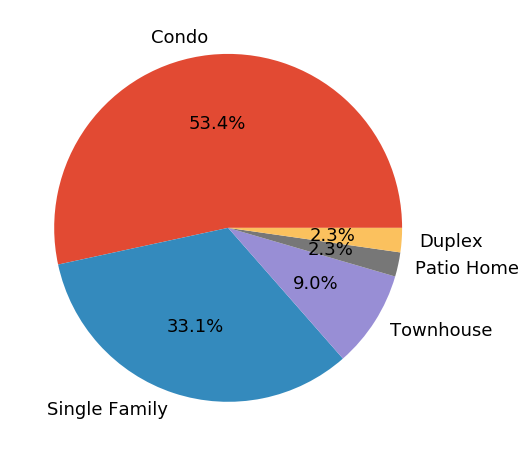

In [69]:
plt.style.use('ggplot')
typecount = listings["Property Type"].value_counts()
typecount.plot(kind="pie",
               # legend = False,
                figsize=(8,8), 
               # colors = ['#66b3ff','#99ff99','#ff9999'], # Get colors that pop
                fontsize = 18, autopct = '%.1f%%', # Round to 1 decimal and include % sign
                )
plt.ylabel('') # Hide the y-label 

Condo is clearly the most common property type, followed by single family. Townhouses, duplexes and patio homes make up the remaining ~12%. 

##### Property Type vs Price

First, we must take out the dollar signs and commas from the price column:

In [72]:
listings['Price'] = listings['Price'].str.replace('$', '')
listings['Price'] = listings['Price'].str.replace(',', '')
listings["Price"] = listings["Price"].astype(int) # obj -> int

Let's see how each property type stacks up against one another in terms of price. I took out properties over 6 million because they were all single families...

In [73]:
listings.nlargest(11, "Price")

,Address,Price,Property Type,Beds,Baths,Square Feet,Garages
89,112 Woodland Rd,39500000,Single Family,5,7,12112,3
21,14 Allerton St,12888888,Single Family,7,8,7450,2
91,21 Sears Rd,10700000,Single Family,5,7,8498,3
58,197 Cabot,8500000,Single Family,6,8,6720,3
24,45 Leicester St,8200000,Single Family,6,8,9600,3
125,11 Cramond Rd,7895000,Single Family,4,7,6580,3
111,286 Warren St,7750000,Single Family,7,6,7761,3
117,204 Clyde St,7500000,Single Family,6,8,7502,3
124,80 Seaver St,6750000,Single Family,7,9,9030,6
132,31 Catlin Rd,6500000,Single Family,5,7,6361,3


 ...and it was more difficult to get an idea of the other property types with a $39.5 million property in the plot. 

Text(-15.789999999999992, 0.5, 'Price')

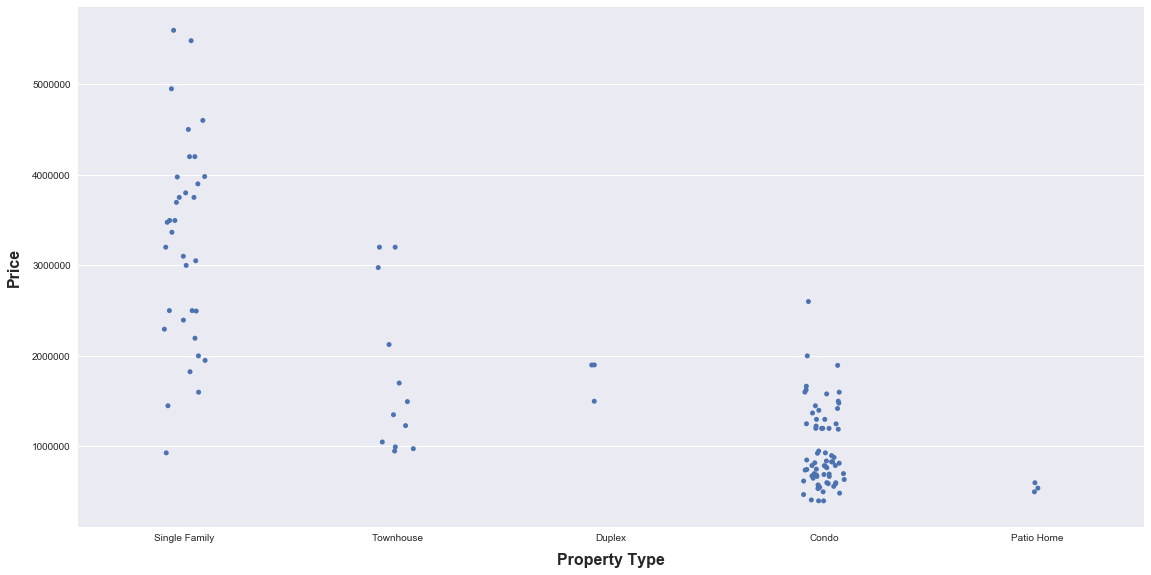

In [157]:
plt.style.use('seaborn')
belowsixmil = listings[listings.Price < 6000000]
sns.catplot('Property Type', 'Price', data = belowsixmil, color = 'b', \
               estimator = np.median, height = 8,  aspect=2)
plt.xlabel("Property Type", size = 16, weight = 'bold', labelpad = 10)
plt.ylabel("Price", size = 16, weight = 'bold', labelpad = 10)

The vast majorities of properties under $1,000,000 are condos. On the other end of the spectrum, the vast majority of expensive properties are single families, unsurprisingly. Patio homes are relatively cheap, while duplexes range a bit pricier, but those sample sizes are extremely small. Overall, this graph just shows how expensive a single family home in Brookline really is. 

### Graphing Prices

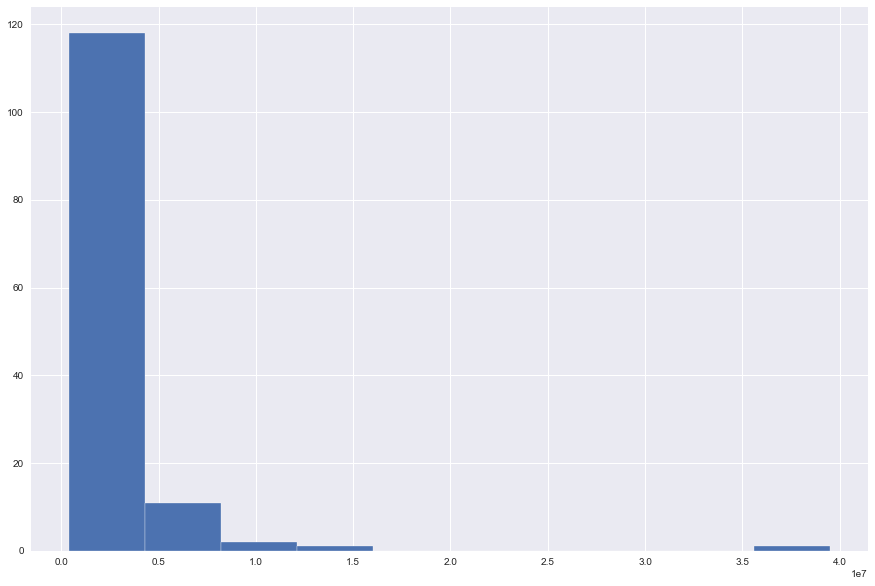

In [114]:
listings.Price.hist(figsize=(15,10))

Pandas wants to do pretty much everything for prices in scientific notation since its values are so large. To avoid having the x axis labeled in terms of e^7, I'm going to create a dataframe "abbvprices" with prices in terms of millions of dollars:

In [108]:
abbvprices = []
ogprices = listings["Price"]
for i in range(len(listings)):
    smaller = ogprices[i]
    abbvprices.append(smaller * .000001)

In [109]:
p = pd.DataFrame({"Abbv. Prices": abbvprices})

I'm going to exclude the 39.5 million dollar property since it is over three times as expensive as the next most expensive home. 

Text(0.5, 1.0, 'Histogram of Brookline Property Prices')

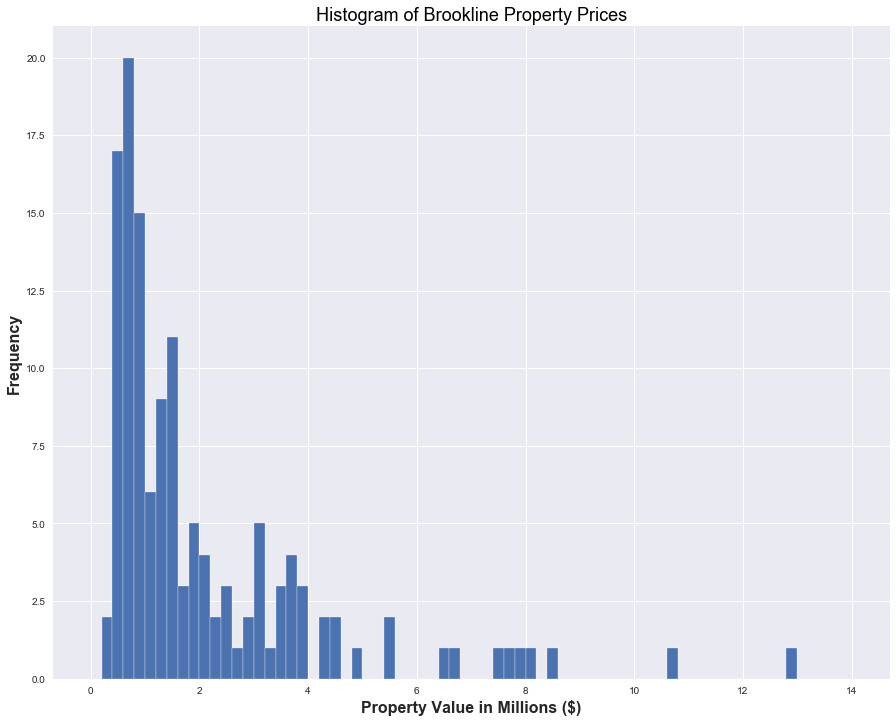

In [134]:
ax = p.plot(kind="hist",
      bins=70,
      range=(0,14),
      legend=False,
      figsize=(15,12))
ax.set_ylim([0,21])
plt.xlabel("Property Value in Millions ($)", weight='bold', size = 16)
plt.ylabel("Frequency", weight='bold', size=16)
plt.title("Histogram of Brookline Property Prices", color="black", size=18)

Zooming in even more:

Text(0.5, 1.0, 'Histogram of Brookline Property Prices Up to 3 Mil')

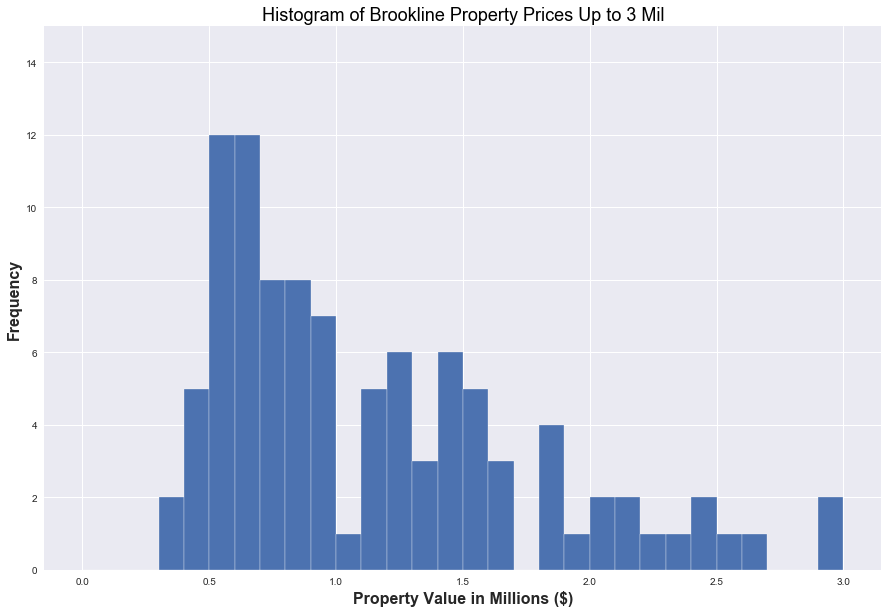

In [138]:
ax = p.plot(kind="hist",
      bins=30,
      range=(0,3),
      legend=False,
      figsize=(15,10))
ax.set_ylim([0,15])
plt.xlabel("Property Value in Millions ($)", weight='bold', size = 16)
plt.ylabel("Frequency", weight='bold', size=16)
plt.title("Histogram of Brookline Property Prices Up to 3 Mil", color="black", size=18)

The most common price range on the graph is .5-1 million. Let's see how many of the properties are between .5-1 mil:

In [119]:
halftoone = len(listings.loc[((listings.Price<=1000000) & (listings.Price >= 500000))])
halftoone

47

In [120]:
print(f"{(round((halftoone/len(listings))*100, 2))}% of properties are between $500,000 and $1 million.")

35.34% of properties are between $500,000 and $1 million.


### Graphing Sq. ft, Beds, Baths and Garages

Converting numerical columns from obj to int:

In [139]:
listings["Beds"] = listings["Beds"].astype(int)
listings["Baths"] = listings["Baths"].astype(int)
listings["Square Feet"] = listings["Square Feet"].astype(int)
listings["Garages"] = listings["Garages"].astype(int)

Descriptive stats:

In [140]:
lastfourcolumns = listings.drop(columns = ["Address", "Price", "Property Type"]) # getting rid of other columns
lastfourcolumns = lastfourcolumns.astype(int) # obj -> int
lastfourcolumns.describe().round(2) # was originally 6 decimal places

,Beds,Baths,Square Feet,Garages
count,133.00,133.00,133.00,133.00
mean,3.38,3.33,2856.31,1.13
std,1.81,2.19,2394.34,1.13
min,0.00,1.00,375.00,0.00
25%,2.00,2.00,1105.00,0.00
50%,3.00,3.00,1930.00,1.00
75%,5.00,5.00,3644.00,2.00
max,10.00,9.00,12112.00,6.00


##### Square Feet

Text(0.5, 1.0, 'Histogram of Brookline Property Square Feet')

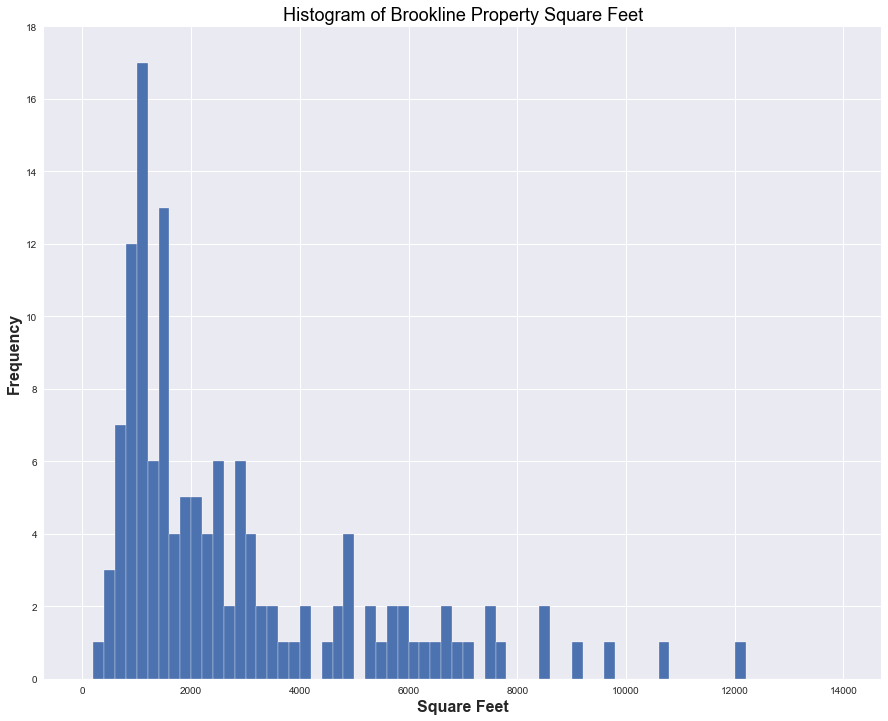

In [142]:
plt.style.use('seaborn')
ax = listings["Square Feet"].hist(bins=70,
                             range=(0,14000),
                            figsize=(15,12))
ax.set_ylim([0,18])
plt.xlabel("Square Feet", weight='bold', size = 16)
plt.ylabel("Frequency", weight='bold', size=16)
plt.title("Histogram of Brookline Property Square Feet", color="black", size=18)

##### Square ft. vs Price

Text(0, 0.5, 'Price ($)')

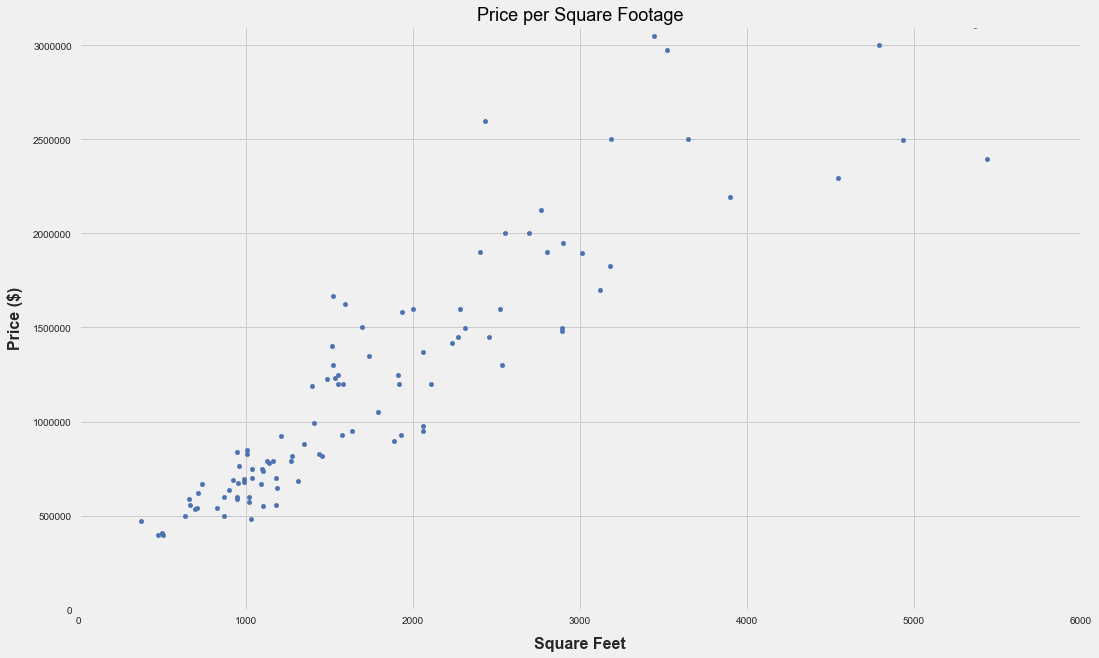

In [144]:
plt.style.use("fivethirtyeight")
listings.plot(kind="scatter",
                x="Square Feet", 
                y="Price",
                figsize=(16,10))
plt.xlim(0, 6000)
plt.ylim(0, 3100000)
plt.title("Price per Square Footage", size=18, color="black")
plt.xlabel("Square Feet", size = 16, weight = 'bold', labelpad = 10)
plt.ylabel("Price ($)", size = 16, weight = 'bold', labelpad = 10)

The biggest outlier here seems like the property in the 2-2.5 mil and 5-6,000 sqft ranges. Let's find out which one that is:

In [175]:
listings.loc[((listings.Price>2000000)&(listings.Price<2500000)&(listings["Square Feet"]>5000)&(listings["Square Feet"]<6000))]

,Address,Price,Property Type,Beds,Baths,Square Feet,Garages
116,612 Newton St,2395000,Single Family,6,6,5436,2


Someone with 2.4 mil should get on that.

##### Beds, Baths, Garages vs Price

Heatmap of Beds vs Baths with Price annotated and color scaled:

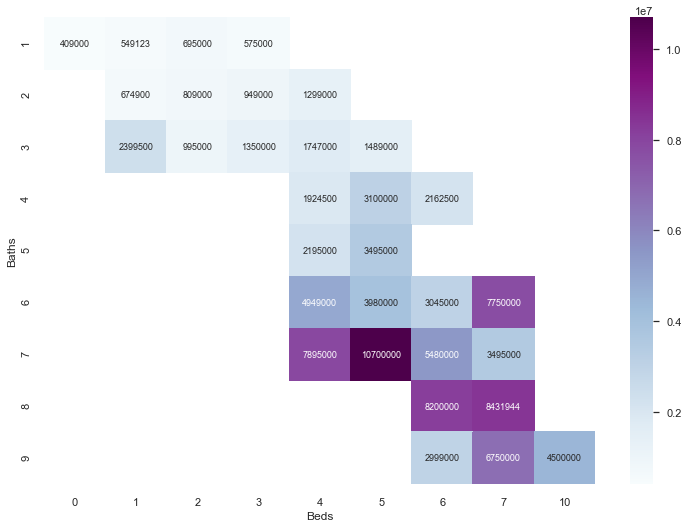

In [165]:
sns.set(rc={'figure.figsize':(11,8)})
sns.heatmap(listings.groupby([
        'Baths', "Beds"]).Price.median().unstack(),annot=True, annot_kws={"size": 9}, fmt=".0f", cmap="BuPu")
sns.set_style(style='white')

In [163]:
listings.loc[(listings.Beds == 5) & (listings.Baths == 7)]

,Address,Price,Property Type,Beds,Baths,Square Feet,Garages
89,112 Woodland Rd,39500000,Single Family,5,7,12112,3
91,21 Sears Rd,10700000,Single Family,5,7,8498,3
132,31 Catlin Rd,6500000,Single Family,5,7,6361,3


The square with 5 Beds / 7 Baths is indeed the square with the 39.5 million property. 

Narrowing it down a bit:

In [148]:
listings22 = listings.loc[((listings.Baths <= 5) & (listings.Beds <= 5))] # creating the data we want

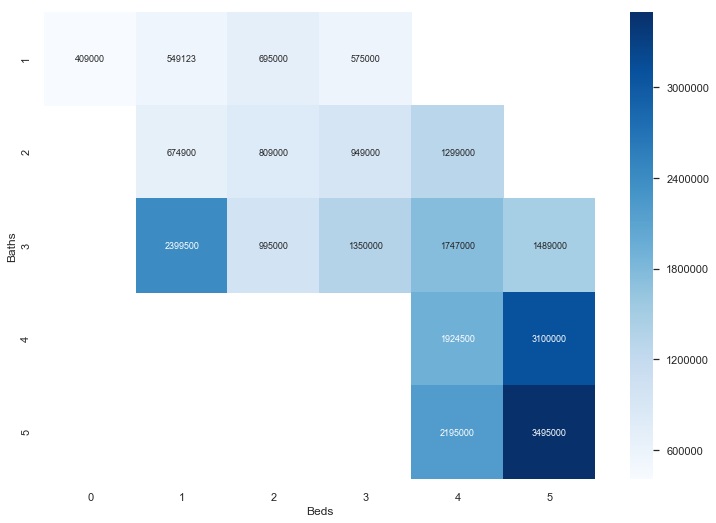

In [164]:
sns.heatmap(listings22.groupby([
        'Baths', "Beds"]).Price.median().unstack(),annot=True, annot_kws={"size": 9}, fmt=".0f", cmap="Blues")

##### Boxplot of Garages

I'm gonna exclude properties over 10 mil to avoid scientific notation and to see the plot better:

In [166]:
listings22 = listings.loc[((listings.Price < 10000000))]

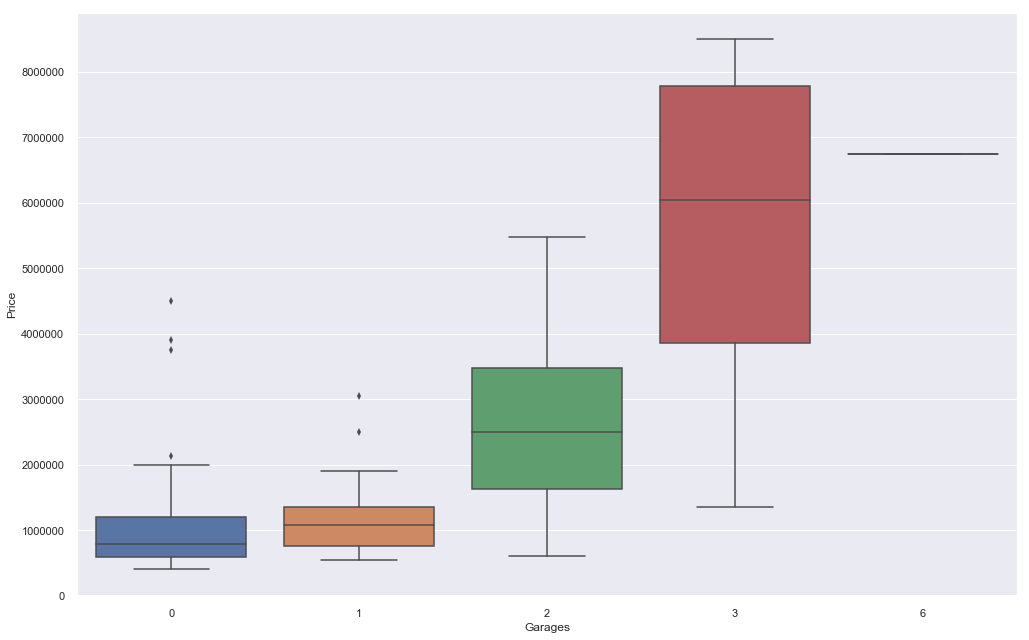

In [169]:
sns.set(rc={'figure.figsize':(15,10)})
sns.boxplot(y='Price', x='Garages', data= listings22)

In [170]:
listings.loc[((listings.Garages == 3))].sort_values(['Price'], ascending=[False])

,Address,Price,Property Type,Beds,Baths,Square Feet,Garages
89,112 Woodland Rd,39500000,Single Family,5,7,12112,3
91,21 Sears Rd,10700000,Single Family,5,7,8498,3
58,197 Cabot,8500000,Single Family,6,8,6720,3
24,45 Leicester St,8200000,Single Family,6,8,9600,3
125,11 Cramond Rd,7895000,Single Family,4,7,6580,3
111,286 Warren St,7750000,Single Family,7,6,7761,3
117,204 Clyde St,7500000,Single Family,6,8,7502,3
132,31 Catlin Rd,6500000,Single Family,5,7,6361,3
122,156 Ivy St,5595000,Single Family,5,5,6747,3
92,60 Sargent Beechwood,4949000,Single Family,4,6,5663,3


The properties with three garages are all pretty pricey. 

##### Boxplots for Beds and Baths

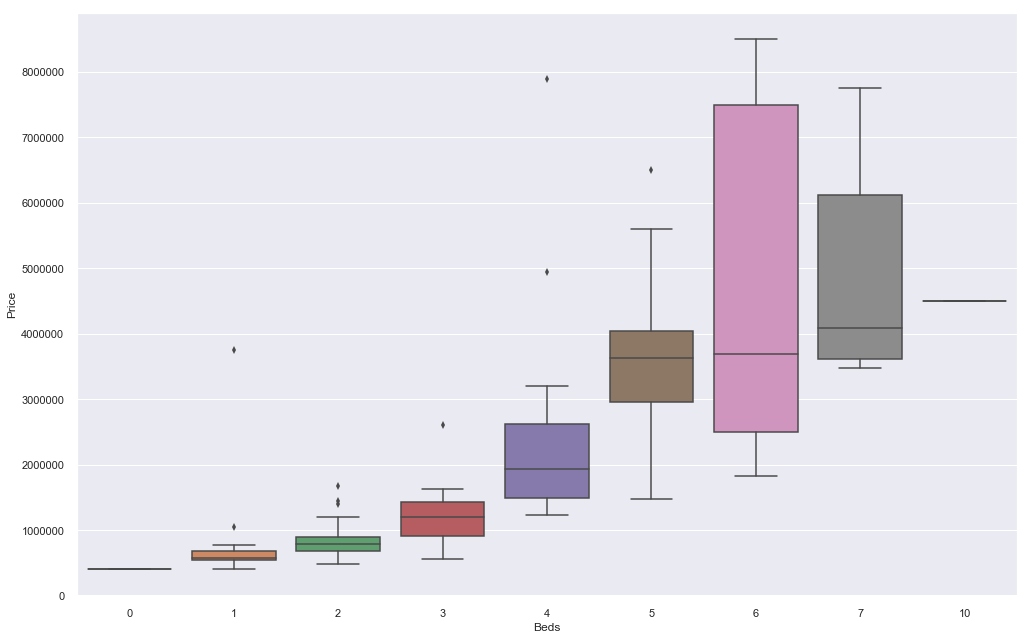

In [172]:
sns.boxplot(y='Price', x='Beds', data=listings22)

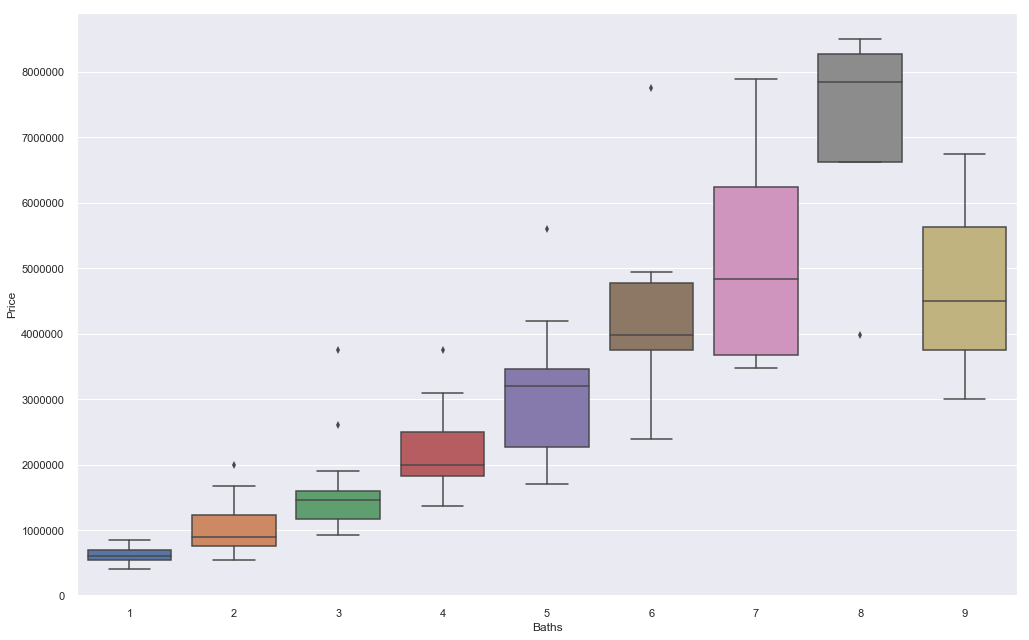

In [174]:
sns.boxplot(y='Price', x='Baths', data=listings22) #.loc[(0<nooutliers.Beds) & (nooutliers.Beds<8)])

No real surprises here; the median prices rise just about every time. There are definitely some surpising outliers, especially the property that has one bed and is nearly 4 mil. 

## Conclusion

That's my project, thanks a ton for reading if you got this far. I had fun doing this as it was definitely a challenge, Beautiful Soup is something that is useful to know so I'm glad I did it. Feel free to use this code for any property listings you want to scrape, just know that it will have to be on Coldwell Banker's site, that is until they change it and this code is useless. 